In [12]:
from magpi.prelude import *
from magpi.calc import laplace
from magpi.r_fun import cube
from magpi.integrate import integrate, gauss
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1

In [19]:
x_dom = array(Sobol(2, seed=0).random_base2(10))
adf = cube(1)

def solution(x):
    return sin(2*pi * x[0]) * sin(2*pi * x[1])

abs_error = lambda model: sqrt(integrate(lambda x: jnp.abs(model(x) - solution(x)) ** 2, 
                                         [jnp.linspace(0, 1, 10), jnp.linspace(0, 1, 10)], method=gauss(8)))

In [37]:
hidden_nodes = 8  # 2 ** 8
W_elm = array(Sobol(2, seed=1).random_base2(hidden_nodes))  # ELM input params
l2_reg = 1e-4  # ridge regularization
gamma = 20.0  # kernel parameter

# define hard constraint ELM hidden layer with RBF activations:
u_elm = lambda x: adf(x) * exp(-gamma * norm(x - W_elm, axis=-1) ** 2)
Q = vmap(lambda x: laplace(u_elm)(x))(x_dom)
U, S, VT = jax.scipy.linalg.svd(Q, full_matrices=False, lapack_driver="gesvd")
Q_inv = VT.T * (S / (S ** 2 + l2_reg)) @ U.T  # compute pseudoinverse

b = vmap(laplace(solution))(x_dom)  # compute rhs
beta = Q_inv @ b  # compute ELM output params
elm_model = lambda x: u_elm(x) @ beta  # define final model

print("L2 error:", abs_error(elm_model))  # evaluate model error


L2 error: 0.0003937337


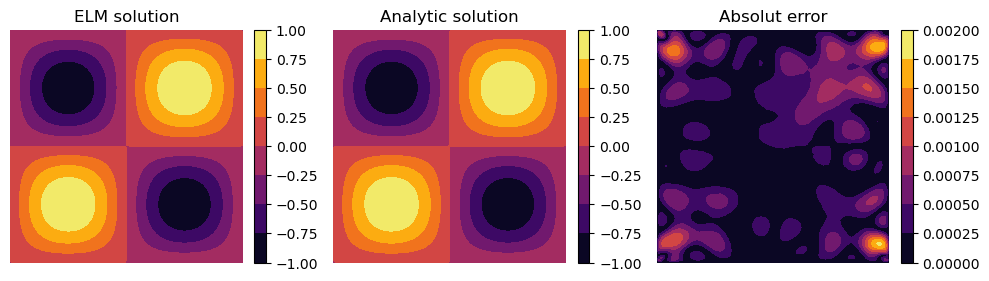

In [38]:
def add_colorbar(im, aspect=20, pad_fraction=1, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

def plot_solution(model):
    x = linspace(0, 1, 100)
    y = linspace(0, 1, 100)
    X, Y = meshgrid(x, y, indexing='xy')
    _X = stack([X, Y], axis=-1)

    Z_pred = jnp.apply_along_axis(model, -1, _X)
    Z_true = jnp.apply_along_axis(solution, -1, _X)

    fig = plt.figure(figsize=(10, 3))
    ax1, ax2, ax3 = fig.subplots(1, 3)

    plt.sca(ax1)
    plt.axis('equal')
    plt.title("ELM solution")
    p = plt.contourf(X, Y, Z_pred, cmap="inferno")
    add_colorbar(p)
    plt.axis("off")

    plt.sca(ax2)
    plt.axis('equal')
    plt.title("Analytic solution")
    p = plt.contourf(X, Y, Z_true, cmap="inferno")
    add_colorbar(p)
    plt.axis("off")

    plt.sca(ax3)
    plt.axis('equal')
    plt.title("Absolut error")
    p = plt.contourf(X, Y, abs(Z_pred - Z_true), cmap="inferno")
    add_colorbar(p)
    plt.axis("off")
    plt.tight_layout()

plot_solution(elm_model)